<a href="https://colab.research.google.com/github/beatrizrgarcia/solowmodel/blob/main/solowmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install seaborn
!pip install matplotlib
!pip install ipympl
!pip install scipy

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.iolib.summary2 import summary_col
from scipy.stats import t
import statsmodels.api as sm
import seaborn as sns

In [23]:
from google.colab import output
output.enable_custom_widget_manager()

Instalação e importação de pacotes importantes para a realização do modelo

In [24]:
pwt = pd.read_excel("pwt.xlsx")

In [25]:
delta = 0.05
first_year = 1960
last_year = 2019

oil_countries =  ['Bahrain', 'Gabon', 'Iran (Islamic Republic of)', 'Iraq', 'Kuwait', 'Oman', 'Saudi Arabia', 'United Arab Emirates', 'Lesotho']
notoils = pwt.loc[~pwt["country"].isin(oil_countries)]

first_year_data = notoils[notoils["year"] == first_year].dropna(subset=["rgdpo", "emp"])
countries_in_first_year = first_year_data["country"].unique()

pwt_solow = notoils[['year', 'country', 'rgdpo', 'pop', 'emp', 'csh_i', 'hc']]
pwt_solow = pwt_solow[
    (pwt_solow["year"] <= last_year)
    & (pwt_solow["country"].isin(countries_in_first_year))
]
pwt_solow_grouped = pwt_solow.groupby('country')
pwt_solow['n'] = pd.NA

for group_name, group_data in pwt_solow_grouped:
    group_index = group_data.index
    n_values = (group_data['emp'] - group_data['emp'].shift(1)) / group_data['emp'].shift(1)
    n_values = n_values.replace([np.inf, -np.inf], np.nan)
    pwt_solow.loc[group_index, 'n'] = n_values.expanding().mean()

- Importação da base mais atualizada da PWT
- Consideração de g_delta como 0.05
- Retirada dos países petrolíferos da base da PWT (motivo: podem distorcer os resultados) e decisão de considerar dados da PWT apenas a partir de 1970
- Criação de um novo df a partir da base da PWT sem os países petrolíferos que considera apenas as colunas: 'year', 'country', 'rgdpo' (Produto Interno Bruto real no lado da produção a preços de paridade do poder de compra encadeados - em milhões de dólares em 2019), 'pop'(população em milhões), 'emp' (nº de pessoas empregadas em milhões), 'hc'(Índice de capital humano), 'csh_i' ( parcela da formação bruta de capital físico)
- Criação de first_year_data = notoils[notoils["year"] == first_year].dropna(subset=["rgdpo", "emp"]) que seleciona os dados do DataFrame notoils onde o ano ("year") é igual a first_year. Em seguida, remove as linhas que têm valores ausentes (NaN) nas colunas "rgdpo" e "emp". Os dados resultantes são armazenados em first_year_data e tem como objetivo eliminar países que não armazem dados sobre tais colunas.
- countries_in_first_year = first_year_data["country"].unique() obtém a lista única de países presentes nos dados do primeiro ano (first_year_data).
- Retirada de valores nulos do novo df (motivo: várias funções e pacotes do Python não funcionam com valores NaN)
- pwt_solow_grouped = pwt_solow.groupby('country'): agrupa o DataFrame pwt_solow pelo nome do país para não ocorrer distorções
- pwt_solow['n'] = pd.NA adiciona uma nova coluna chamada 'n' ao DataFrame pwt_solow com todos os valores inicializados como ausentes (cálculo será realizado posteriormente).
- Ao final do código é realizado um loop que itera sobre cada grupo de dados de país (group_data) no DataFrame agrupado pwt_solow_grouped. Para cada grupo, calcula a taxa de crescimento do emprego (n_values) em relação ao ano anterior, substituindo infinitos por NaN. Em seguida, atualiza a coluna 'n' no DataFrame pwt_solow com a média acumulativa dessas taxas de crescimento. A função expanding().mean() é utilizada para calcular a média acumulativa.


In [26]:
pwt_solow['gdp_pw'] = pwt_solow['rgdpo'] / pwt_solow['emp']
pwt_solow['log_gdp_pw'] = np.log(pwt_solow['gdp_pw'])
pwt_solow['investment'] = pwt_solow.groupby('country')['csh_i'].transform("mean")
pwt_solow['investment'] = pwt_solow['investment'].replace([np.inf, -np.inf], np.nan)
pwt_solow['n'] = pwt_solow['n'].replace([np.inf, -np.inf], np.nan)
pwt_solow['restricted1'] = np.log(pwt_solow['investment']) - np.log(pwt_solow['n'] + delta)

pwt_solow = pwt_solow.reset_index(drop=True)


- Criação da cvariável 'gdp_pw' no df que será caracterizada pela divisão dos valores de 'rgdpo' por 'emp' para cada país. Assim, 'gdp_pw" será o PIB por trabalhador
- Criação da variável 'log_gdp_pw' no df que será o log de 'gdp_pw'
- Criação da variável 'investment' que calcula, para cada país, a média dos valores da variável 'csh_i'. Sendo, portanto, a taxa de investimento/poupança de cada país. Assim, para cada país no DataFrame, calcula a média da coluna 'csh_i' usando a função groupby e a função transform("mean") que é utilizada para atribuir a média de cada grupo ao correspondente país. Ademais, é necessário substituir infinitos (np.inf) e menos infinitos (-np.inf) na coluna 'investment' por valores NaN (Not a Number). Isso é feito para lidar com casos em que o cálculo da média resulta em infinito.
- Criação da variável 'restricted1' que calcula a expressão:
 log * 'investment' - log * ('n' + delta)
- Como a variável 'n' (taxa de crescimento populacional) já foi posteriormente definida, é necessário substituir infinitos (np.inf) e menos infinitos (-np.inf) na coluna 'n' por valores NaN para lidar com casos em que o cálculo da taxa de crescimento ('n') resulta em infinito.



In [27]:
def implied_alpha(reg):
    alpha = reg.params[1] / (1 + reg.params[1])
    x2 = 0

    se = np.sqrt(reg.cov_params().iloc[1, 1])

    t_stat = alpha / se

    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=reg.df_resid))

    stars = ''
    if p_value < 0.01:
        stars = '***'
    elif p_value < 0.05:
        stars = '**'
    elif p_value < 0.1:
        stars = '*'

    return alpha, p_value, stars

Cálculo do Implied_Alpha (única parte que está dando valor discrepante - tentar refazer)

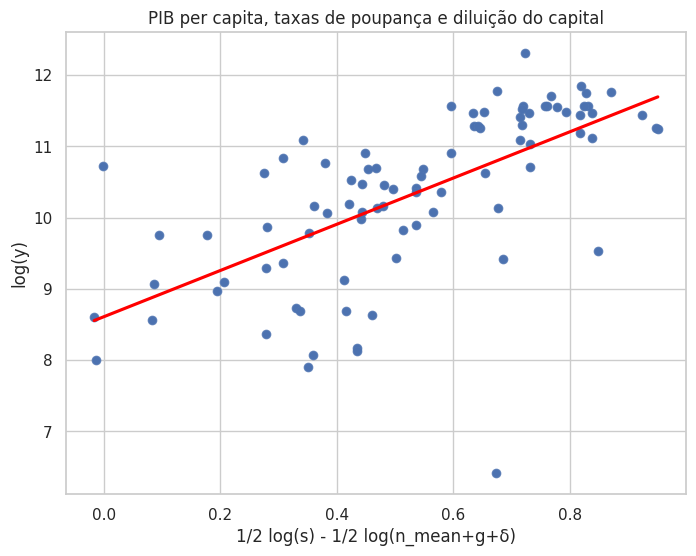

In [28]:
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))

x_data = 0.5 * np.log(pwt_solow['investment']) - 0.5 * np.log(pwt_solow['n'] + delta)
y_data = pwt_solow[pwt_solow["year"] == last_year]['log_gdp_pw']

pwt_converg = pd.DataFrame({'x': x_data, 'y': y_data})

sns.scatterplot(x='x', y='y', data=pwt_converg)
sns.regplot(x='x', y='y', data=pwt_converg, ci=None, line_kws={"color": "red"})

plt.title('PIB per capita, taxas de poupança e diluição do capital')
plt.xlabel('1/2 log(s) - 1/2 log(n_mean+g+δ)')
plt.ylabel('log(y)')

plt.show()

- Criação do gráfico sendo:
eixo x: 0.5 * log (investment) - 0.5 * log (n + delta)
eixo y: log_gdp_pw


In [29]:
pwt_solow19 = pwt_solow[pwt_solow['year'] == last_year]

modelo = 'log_gdp_pw ~ np.log(investment) + np.log(n + delta)'
OECD_countries = ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Republic of Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
OECD = pwt_solow19.loc[pwt["country"].isin(OECD_countries)]

reg1_1 = sm.OLS.from_formula(modelo, data=pwt_solow19).fit()
reg1_2 = sm.OLS.from_formula(modelo, data=pwt_solow19[pwt_solow19['pop'] > 1]).fit()
reg1_3 = sm.OLS.from_formula(modelo, data=pwt_solow19[pwt_solow19['country'].isin(OECD_countries)]).fit()

summary_table = pd.DataFrame()
summary_table[''] = ['ln(s)', 'ln(n+g+δ)', 'Constant', 'Observations', 'Adjusted R2']
summary_table.set_index('', inplace=True)

summary_table['Non-oil'] = [f'{reg1_1.params["np.log(investment)"]:.3f}***', f'{reg1_1.params["np.log(n + delta)"]:.3f}***', f'{reg1_1.params["Intercept"]:.3f}', f'{int(reg1_1.nobs)}', f'{reg1_1.rsquared_adj:.3f}']
summary_table['Intermediate'] = [f'{reg1_2.params["np.log(investment)"]:.3f}***', f'{reg1_2.params["np.log(n + delta)"]:.3f}***', f'{reg1_2.params["Intercept"]:.3f}', f'{int(reg1_2.nobs)}', f'{reg1_2.rsquared_adj:.3f}']
summary_table['OECD'] = [f'{reg1_3.params["np.log(investment)"]:.3f}**', f'{reg1_3.params["np.log(n + delta)"]:.3f}', f'{reg1_3.params["Intercept"]:.3f}***', f'{int(reg1_3.nobs)}', f'{reg1_3.rsquared_adj:.3f}']

summary_table.loc['ln(s)'] = summary_table.loc['ln(s)'] + f'  ({reg1_1.bse["np.log(investment)"]:.3f})'
summary_table.loc['ln(n+g+δ)'] = summary_table.loc['ln(n+g+δ)'] + f'  ({reg1_1.bse["np.log(n + delta)"]:.3f})'
summary_table.loc['Constant'] = summary_table.loc['Constant'] + f'  ({reg1_1.bse["Intercept"]:.3f})'

print (summary_table)

                         Non-oil        Intermediate                OECD
                                                                        
ln(s)          1.209***  (0.241)   1.189***  (0.241)    0.739**  (0.241)
ln(n+g+δ)     -3.655***  (0.708)  -3.702***  (0.708)     -0.667  (0.708)
Constant          2.533  (2.045)      2.374  (2.045)  10.561***  (2.045)
Observations                  89                  84                  28
Adjusted R2                0.457               0.440               0.193


- Em primeiro lugar, é realizado uma variável nomeada 'modelo' que será a formulá utilizada para a regressão linear múltipla (OLS) tendo a variável log_gdp_pw como variável dependente e [log (investment)] e [log (n+ delta)] como variavéis independentes.
- Definição dos países da OCDE e criação de uma variável nomeada 'OCDE' que seleciona, diretamente, da variável pwt_solow os países pertencentes ao grupo
- Uso da biblioteca Statsmodels para criação de um modelo de regressão linear com base em uma fórmula especificada em 'modelo' e usando o DataFrame pwt_solow19 (base da pwt_solow que contenha apenas os dados de 2019) como os dados de entrada para o modelo - países oils são excluídos.
- Uso da biblioteca Statsmodels para criação de um modelo de regressão linear com base em uma fórmula especificada em 'modelo' e usando o DataFrame pwt_solow19 (base da pwt_solow que contenha apenas os dados de 2019) como os dados de entrada para o modelo - países oils são excluídos. Nesse caso, há uma condição: apenas os países que contenham mais de 1 de população entrarão na regressão
- Uso da biblioteca Statsmodels para criação de um modelo de regressão linear com base em uma fórmula especificada em 'modelo' e usando o DataFrame pwt_solow19 (base da pwt_solow que contenha apenas os dados de 2019) como os dados de entrada para o modelo - países oils são excluídos. Nesse caso, há uma condição: apenas os países membros da OCDE entrarão na regressão
- Criação de três colunas em uma tabela chamada 'summary_table', onde cada coluna contém informações resumidas de três modelos de regressão - sendo a primeira coluna "Non-Oils" contendo informações da primeira regressão, a segunda coluna "Intermediate" contendo informações da segunda regressão e "OCDE" contendo informações da terceira regressão.
- As informações contidadas na tabela, para cada coluna e calculada para cada regressão, serão: o coeficiente estimado para a variável "np.log(investment)" com formatação em 3 casas decimais e com três asteriscos no final (os asteriscos podem indicar que o coeficiente é estatisticamente significativo), segundo valor é o coeficiente estimado para a variável "np.log(n + delta)" no modelo, também com formatação em 3 casas decimais e três asteriscos, o terceiro valor é o coeficiente estimado para a constante (Intercept) no modelo com formatação em 3 casas decimais, o quarto valor é o número de observações no modelo, convertido em inteiro com int e o quinto valor é o valor do coeficiente de determinação ajustado (R² ajustado) para o modelo com formatação em 3 casas decimais.


In [32]:
model2 = 'log_gdp_pw ~ restricted1'

#FALTANDO IMPLIED ALPHA

reg2_1 = sm.OLS.from_formula(model2, data=pwt_solow19).fit()
reg2_2 = sm.OLS.from_formula(model2, data=pwt_solow19[pwt_solow19['pop'] > 1]).fit()
reg2_3 = sm.OLS.from_formula(model2, data=pwt_solow19[pwt_solow19['country'].isin(OECD_countries)]).fit()

summary_table2 = pd.DataFrame(index=[''] * 6)
summary_table2[''] = ['ln(s) - ln(n+g+δ)', 'Constant', 'Implied Alpha', 'Observations', 'Adjusted R2', '']  # Adicionando um espaço em branco para corresponder ao índice extra na tabela
summary_table2.set_index('', inplace=True)

for reg, name in zip([reg2_1, reg2_2, reg2_3], ['Non-oil', 'Intermediate', 'OECD']):
    alpha, p_value, stars = implied_alpha(reg)



    summary_table2[name] = [
    f'{reg.params["restricted1"]:.3f}{stars}',
    f'{reg.params["Intercept"]:.3f}***',
    f'{alpha:.3f}{stars}',
    f'{int(reg.nobs)}',
    f'{reg.rsquared_adj:.3f}',
    ''  # Placeholder for Adjusted R2
]


    summary_table2.loc['ln(s) - ln(n+g+δ)', name] += f'  ({reg.bse["restricted1"]:.3f})'
    summary_table2.loc['Constant', name] += f'  ({reg.bse["Intercept"]:.3f})'

print(summary_table2)

                             Non-oil       Intermediate                OECD
                                                                           
ln(s) - ln(n+g+δ)  1.622***  (0.207)  1.644***  (0.224)     0.711*  (0.240)
Constant           8.609***  (0.241)  8.585***  (0.254)  10.401***  (0.357)
Implied Alpha               0.619***           0.622***              0.416*
Observations                      89                 84                  28
Adjusted R2                    0.407              0.389               0.224
                                                                           


- Criação do model2 que será 'log_gdp_pw ~ restricted1'.
As três regressões lineares são ajustados usando o método de Mínimos Quadrados Ordinários (OLS), sendo que:
reg2_1 é a regressão para todo o conjunto de dados - PWT menos países petroleiros
reg2_2 é a regressão para o subconjunto onde 'pop' é maior que 1.
reg2_3 é a regressão para os países na lista especificada (OECD_countries)
- Uma tabela vazia (summary_table2) é criada para armazenar os resultados das regressões. Os rótulos das linhas são definidos como ['ln(s) - ln(n+g+δ)', 'Constant', 'Implied_Alpha', 'Observações', 'R2 Ajustado']- não consegui calcular o Implied_Alpha porque não entendi como ele foi criado no código em R
- Os coeficientes estimados, estatísticas e outras informações das regressões são inseridos na tabela summary_table2.
- Implied_Alpha com valores discrepantes
-A tabela summary_table2 é impressa na tela, fornecendo uma visão resumida dos resultados das regressões.



In [33]:
#model 3
model3 = 'log_gdp_pw ~ np.log(investment) + np.log(hc) + np.log(n+delta)'

reg3_1 = sm.OLS.from_formula(model3, data=pwt_solow19).fit()
reg3_2 = sm.OLS.from_formula(model3, data=pwt_solow19[pwt_solow19['pop'] > 1]).fit()
reg3_3 = sm.OLS.from_formula(model3, data=pwt_solow19[pwt_solow19['country'].isin(OECD_countries)]).fit()

summary_table3 = pd.DataFrame()
summary_table3[''] = ['ln(sk)', 'ln(sh)', 'ln(n+g+δ)', 'Constant', 'Observations', 'Adjusted R2']
summary_table3.set_index('', inplace=True)
summary_table3['Non-oil'] = [f'{reg3_1.params["np.log(investment)"]:.3f}***', f'{reg3_1.params["np.log(hc)"]:.3f}***', f'{reg3_1.params["np.log(n + delta)"]:.3f}***', f'{reg3_1.params["Intercept"]:.3f}***', f'{int(reg3_1.nobs)}', f'{reg3_1.rsquared_adj:.3f}']
summary_table3['Intermediate'] = [f'{reg3_2.params["np.log(investment)"]:.3f}***', f'{reg3_2.params["np.log(hc)"]:.3f}***', f'{reg3_2.params["np.log(n + delta)"]:.3f}***', f'{reg3_2.params["Intercept"]:.3f}***', f'{int(reg3_2.nobs)}', f'{reg3_2.rsquared_adj:.3f}']

summary_table3['OECD'] = [f'{reg3_3.params["np.log(investment)"]:.3f}***', f'{reg3_3.params["np.log(hc)"]:.3f}***', f'{reg3_3.params["np.log(n + delta)"]:.3f}***', f'{reg3_3.params["Intercept"]:.3f}***', f'{int(reg3_3.nobs)}', f'{reg3_3.rsquared_adj:.3f}']

summary_table3.loc['ln(sk)'] = summary_table3.loc['ln(sk)'] + f'  ({reg3_1.bse["np.log(investment)"]:.3f})'
summary_table3.loc['ln(sh)'] = summary_table3.loc['ln(sh)'] + f'  ({reg3_1.bse["np.log(hc)"]:.3f})'
summary_table3.loc['ln(n+g+δ)'] = summary_table3.loc['ln(n+g+δ)'] + f'  ({reg3_1.bse["np.log(n + delta)"]:.3f})'
summary_table3.loc['Constant'] = summary_table3.loc['Constant'] + f'  ({reg3_1.bse["Intercept"]:.3f})'

print(summary_table3)

                         Non-oil        Intermediate                OECD
                                                                        
ln(sk)         0.281***  (0.226)   0.189***  (0.226)   0.455***  (0.226)
ln(sh)         2.530***  (0.344)   2.560***  (0.344)   0.801***  (0.344)
ln(n+g+δ)     -2.032***  (0.594)  -2.109***  (0.594)  -0.800***  (0.594)
Constant       2.922***  (1.600)   2.533***  (1.600)   8.846***  (1.600)
Observations                  88                  83                  28
Adjusted R2                0.661               0.653               0.237


- Criação do model3 que será  'log_gdp_pw ~ np.log(investment) + np.log(hc) + np.log(n+delta)'.
As três regressões lineares são ajustados usando o método de Mínimos Quadrados Ordinários (OLS), sendo que:
reg3_1 é a regressão para todo o conjunto de dados - PWT menos países petroleiros
reg3_2 é a regressão para o subconjunto onde 'pop' é maior que 1.
reg3_3 é a regressão para os países na lista especificada (OECD_countries)
- Uma tabela vazia (summary_table3) é criada para armazenar os resultados das regressões. Os rótulos das linhas são definidos como ['ln(sk), ln(sh), 'ln(n+g+δ)' 'Constant','Observações', 'R2 Ajustado']
- Os coeficientes estimados, estatísticas e outras informações das regressões são inseridos na tabela summary_table3.
-A tabela summary_table3 é impressa na tela, fornecendo uma visão resumida dos resultados das regressões.



In [34]:
pwt1 = pd.read_excel("pwt.xlsx")
delta = 0.05
first_year = 1960
last_year = 2019

oil_countries = ['Bahrain', 'Gabon', 'Iran (Islamic Republic of)', 'Iraq', 'Kuwait',
                 'Oman', 'Saudi Arabia', 'United Arab Emirates', 'Lesotho']

notoils = pwt1.loc[~pwt1["country"].isin(oil_countries)]

first_year_data = notoils[notoils["year"] ==
                          first_year].dropna(subset=["rgdpo", "emp"])
countries_in_first_year = first_year_data["country"].unique()

pwt_converg = notoils[['year', 'country',
                       'rgdpo', 'pop', 'emp', 'csh_i', 'hc']]
pwt_converg = pwt_converg[
    (pwt_converg["year"] <= last_year)
    & (pwt_converg["country"].isin(countries_in_first_year))
]
pwt_converg_grouped = pwt_converg.groupby('country')

for group_name, group_data in pwt_converg_grouped:
    group_index = group_data.index
    n_values = (group_data['emp'].shift(-1) - group_data['emp']
                ) / group_data['emp']


    pwt_converg.loc[group_index, 'n'] = n_values.mean(skipna=True)

pwt_converg['gdp_pw'] = pwt_converg['rgdpo'] / pwt_converg['emp']
pwt_converg['log_gdp_pw'] = np.log(pwt_converg['gdp_pw'])
pwt_converg['n'] = pwt_converg['n'].replace([np.inf, -np.inf], np.nan)
pwt_converg['delta_lgdp'] = pwt_converg['log_gdp_pw'].shift(
    -(last_year-first_year)) - pwt_converg['log_gdp_pw']

pwt_converg = pwt_converg.reset_index(drop=True)
pwt_converg = pwt_converg[pwt_converg['year'] == 1960]
pwt_converg = pwt_converg.sort_values(by=['year', 'country'])


Criação do Dataframe pwt_converg para realizar as regressões relativas a Convergência. Assim, o DF pwt_converg é definido e tem as variáveis calculadas de maneira semelhante a pwt_solow calculada anteriormente.
Mudanças:
- cálculo e inclusão da variável delta_lgpd que tem como objetivo representar a variação do ln do produto por trabalhador, assim é calculada utilizando .shift() para deslocar os valores da coluna 'log_gdp_pw' para cima (para linhas anteriores) pelo número de períodos especificado, que é calculado como (last_year - first_year). Assim, cria-se uma versão defasada (shifted) da coluna 'log_gdp_pw' no DataFrame e é subtraído o valor defasado do 'log_gdp_pw' do valor original, resultando na variação ao longo do período especificado.
- A pwt_converg considerará apenas dados referentes ao ano de 1960.


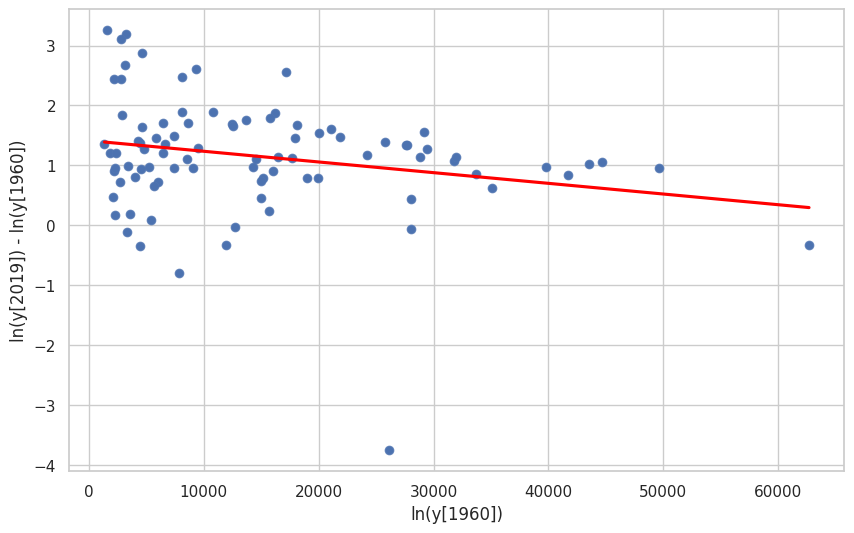

In [35]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gdp_pw', y='delta_lgdp', data=pwt_converg)
sns.regplot(x='gdp_pw', y='delta_lgdp', data=pwt_converg, ci=None, line_kws={"color": "red"})

plt.xlabel("ln(y[1960])")
plt.ylabel("ln(y[2019]) - ln(y[1960])")
plt.show()


Criação do gráfico entre a variação do ln da renda por trabalhador entre 1960 e 2019 (no eixo y) e o nível inicial (1960) da renda por trabalhador (no eixo x).

In [36]:
model_converg = 'delta_lgdp ~ log_gdp_pw'
OECD_countries = ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Republic of Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
OECD = pwt_converg[pwt_converg['country'].isin(OECD_countries)].copy()

reg1_5 = sm.OLS.from_formula(model_converg, data=pwt_converg).fit()
reg2_5 = sm.OLS.from_formula(model_converg, data=pwt_converg[pwt_converg['pop'] > 1]).fit()
reg3_5 = sm.OLS.from_formula(model_converg, data=OECD).fit()

summary_table2 = pd.DataFrame()
summary_table2[''] = ['ln(Y)', 'Constant', 'Observations', 'Adjusted R2']
summary_table2.set_index('', inplace=True)


summary_table2['Non-oil'] = [f'{reg1_5.params["log_gdp_pw"]:.3f}***', f'{reg1_5.params["Intercept"]:.3f}***', f'{int(reg1_5.nobs)}', f'{reg1_5.rsquared_adj:.3f}']
summary_table2['Intermediate'] = [f'{reg2_5.params["log_gdp_pw"]:.3f}***', f'{reg2_5.params["Intercept"]:.3f}***', f'{int(reg2_5.nobs)}', f'{reg2_5.rsquared_adj:.3f}']
summary_table2['OECD'] = [f'{reg3_5.params["log_gdp_pw"]:.3f}**', f'{reg3_5.params["Intercept"]:.3f}***', f'{int(reg3_5.nobs)}', f'{reg3_5.rsquared_adj:.3f}']

summary_table2.loc['ln(Y)'] = summary_table2.loc['ln(Y)'] + f'  ({reg1_5.bse["log_gdp_pw"]:.3f})'
summary_table2.loc['Constant'] = summary_table2.loc['Constant'] + f'  ({reg1_5.bse["Intercept"]:.3f})'

print(summary_table2)


                         Non-oil        Intermediate               OECD
                                                                       
ln(Y)         -0.235***  (0.103)  -0.156***  (0.103)  -0.796**  (0.103)
Constant       3.308***  (0.955)   2.548***  (0.955)  9.397***  (0.955)
Observations                  89                  79                 28
Adjusted R2                0.045               0.011              0.660


- Criação do model_converg que será 'delta_lgdp ~ log_gdp_pw''.
As três regressões lineares são ajustados usando o método de Mínimos Quadrados Ordinários (OLS), sendo que:
reg1_5 é a regressão para todo o conjunto de dados - PWT menos países petroleiros
reg2_5 é a regressão para o subconjunto onde 'pop' é maior que 1.
reg3_5 é a regressão para os países na lista especificada (OECD_countries)
- Uma tabela vazia (summary_table3) é criada para armazenar os resultados das regressões. Os rótulos das linhas são definidos como ['ln(Y), 'Constant','Observações', 'R2 Ajustado']
- Os coeficientes estimados, estatísticas e outras informações das regressões são inseridos na tabela summary_table2.
-A tabela summary_table2 é impressa na tela, fornecendo uma visão resumida dos resultados das regressões.

In [37]:
model3 = 'delta_lgdp ~ log_gdp_pw + np.log(csh_i) + np.log(n+delta)'

reg3_1 = sm.OLS.from_formula(model3, data=pwt_converg).fit()
reg3_2 = sm.OLS.from_formula(model3, data=pwt_converg[pwt_converg['pop'] > 1]).fit()
reg3_3 = sm.OLS.from_formula(model3, data=OECD).fit()

summary_table3 = pd.DataFrame()
summary_table3[''] = ['ln(Y)', 'ln(sk)', 'ln(n+g+δ)', 'Constant', 'Observations', 'Adjusted R2']
summary_table3.set_index('', inplace=True)

summary_table3['Non-oil'] = [f'{reg3_1.params["log_gdp_pw"]:.3f}***', f'{reg3_1.params["np.log(csh_i)"]:.3f}***', f'{reg3_1.params["np.log(n + delta)"]:.3f}***', f'{reg3_1.params["Intercept"]:.3f}***', f'{int(reg3_1.nobs)}', f'{reg3_1.rsquared_adj:.3f}']
summary_table3['Intermediate'] = [f'{reg3_2.params["log_gdp_pw"]:.3f}***', f'{reg3_2.params["np.log(csh_i)"]:.3f}***', f'{reg3_2.params["np.log(n + delta)"]:.3f}***', f'{reg3_2.params["Intercept"]:.3f}***', f'{int(reg3_2.nobs)}', f'{reg3_2.rsquared_adj:.3f}']
summary_table3['OECD'] = [f'{reg3_3.params["log_gdp_pw"]:.3f}***', f'{reg3_3.params["np.log(csh_i)"]:.3f}***', f'{reg3_3.params["np.log(n + delta)"]:.3f}***', f'{reg3_3.params["Intercept"]:.3f}***', f'{int(reg3_3.nobs)}', f'{reg3_3.rsquared_adj:.3f}']

summary_table3.loc['ln(Y)'] = summary_table3.loc['ln(Y)'] + f'  ({reg3_1.bse["log_gdp_pw"]:.3f})'
summary_table3.loc['ln(sk)'] = summary_table3.loc['ln(sk)'] + f'  ({reg3_1.bse["np.log(csh_i)"]:.3f})'
summary_table3.loc['ln(n+g+δ)'] = summary_table3.loc['ln(n+g+δ)'] + f'  ({reg3_1.bse["np.log(n + delta)"]:.3f})'
summary_table3.loc['Constant'] = summary_table3.loc['Constant'] + f'  ({reg3_1.bse["Intercept"]:.3f})'

print(summary_table3)


                         Non-oil        Intermediate                OECD
                                                                        
ln(Y)         -0.494***  (0.111)  -0.400***  (0.111)  -0.754***  (0.111)
ln(sk)         0.219***  (0.131)   0.082***  (0.131)  -0.059***  (0.131)
ln(n+g+δ)     -3.108***  (0.691)  -3.531***  (0.691)  -1.025***  (0.691)
Constant      -2.195***  (1.980)  -4.480***  (1.980)   6.041***  (1.980)
Observations                  89                  79                  28
Adjusted R2                0.251               0.239               0.689


- Criação do model3 que será  'delta_lgdp ~ log_gdp_pw + np.log(csh_i) + np.log(n+delta)'.
As três regressões lineares são ajustados usando o método de Mínimos Quadrados Ordinários (OLS), sendo que:
reg3_1 é a regressão para todo o conjunto de dados - PWT menos países petroleiros
reg3_2 é a regressão para o subconjunto onde 'pop' é maior que 1.
reg3_3 é a regressão para os países na lista especificada (OECD_countries)
- Uma tabela vazia (summary_table3) é criada para armazenar os resultados das regressões. Os rótulos das linhas são definidos como ['ln (Y)', ln(sk), 'ln(n+g+δ)' 'Constant','Observações', 'R2 Ajustado']
- Os coeficientes estimados, estatísticas e outras informações das regressões são inseridos na tabela summary_table3.
-A tabela summary_table3 é impressa na tela, fornecendo uma visão resumida dos resultados das regressões.

In [38]:
model4 = 'delta_lgdp ~ log_gdp_pw + np.log(csh_i) + np.log(hc) + np.log(n+delta)'

reg4_1 = sm.OLS.from_formula(model4, data=pwt_converg).fit()
reg4_2 = sm.OLS.from_formula(model4, data=pwt_converg[pwt_converg['pop'] > 1]).fit()
reg4_3 = sm.OLS.from_formula(model4, data=OECD).fit()

summary_table3 = pd.DataFrame()
summary_table3[''] = ['ln(Y)', 'ln(sk)','ln(sh)','ln(n+g+δ)', 'Constant', 'Observations', 'Adjusted R2']
summary_table3.set_index('', inplace=True)
summary_table3['Non-oil'] = [f'{reg4_1.params["log_gdp_pw"]:.3f}***', f'{reg4_1.params["np.log(csh_i)"]:.3f}***',  f'{reg4_1.params["np.log(hc)"]:.3f}***', f'{reg4_1.params["np.log(n + delta)"]:.3f}***', f'{reg4_1.params["Intercept"]:.3f}***', f'{int(reg4_1.nobs)}', f'{reg4_1.rsquared_adj:.3f}']
summary_table3['Intermediate'] = [f'{reg4_2.params["log_gdp_pw"]:.3f}***', f'{reg4_2.params["np.log(csh_i)"]:.3f}***',f'{reg4_2.params["np.log(hc)"]:.3f}***', f'{reg4_2.params["np.log(n + delta)"]:.3f}***', f'{reg4_2.params["Intercept"]:.3f}***', f'{int(reg4_2.nobs)}', f'{reg4_2.rsquared_adj:.3f}']
summary_table3['OECD'] = [f'{reg4_3.params["log_gdp_pw"]:.3f}***', f'{reg4_3.params["np.log(csh_i)"]:.3f}***', f'{reg4_3.params["np.log(hc)"]:.3f}***', f'{reg4_3.params["np.log(n + delta)"]:.3f}***', f'{reg4_3.params["Intercept"]:.3f}***', f'{int(reg4_3.nobs)}', f'{reg4_3.rsquared_adj:.3f}']

summary_table3.loc['ln(Y)'] = summary_table3.loc['ln(Y)'] + f'  ({reg4_1.bse["log_gdp_pw"]:.3f})'
summary_table3.loc['ln(sk)'] = summary_table3.loc['ln(sk)'] + f'  ({reg4_1.bse["np.log(csh_i)"]:.3f})'
summary_table3.loc['ln(sh)'] = summary_table3.loc['ln(sh)'] + f'  ({reg4_1.bse["np.log(hc)"]:.3f})'
summary_table3.loc['ln(n+g+δ)'] = summary_table3.loc['ln(n+g+δ)'] + f'  ({reg4_1.bse["np.log(n + delta)"]:.3f})'
summary_table3.loc['Constant'] = summary_table3.loc['Constant'] + f'  ({reg4_1.bse["Intercept"]:.3f})'

print(summary_table3)


                         Non-oil        Intermediate                OECD
                                                                        
ln(Y)         -0.760***  (0.134)  -0.688***  (0.134)  -0.839***  (0.134)
ln(sk)         0.131***  (0.128)   0.017***  (0.128)  -0.092***  (0.128)
ln(sh)         1.569***  (0.510)   1.502***  (0.510)   0.379***  (0.510)
ln(n+g+δ)     -1.485***  (0.833)  -1.988***  (0.833)  -0.883***  (0.833)
Constant       3.746***  (2.642)   1.506***  (2.642)   6.948***  (2.642)
Observations                  88                  78                  28
Adjusted R2                0.325               0.308               0.697


- Criação do model4 que será  'delta_lgdp ~ log_gdp_pw + np.log(csh_i) + np.log(hc) + np.log(n+delta)'.
As três regressões lineares são ajustados usando o método de Mínimos Quadrados Ordinários (OLS), sendo que:
reg4_1 é a regressão para todo o conjunto de dados - PWT menos países petroleiros
reg4_2 é a regressão para o subconjunto onde 'pop' é maior que 1.
reg4_3 é a regressão para os países na lista especificada (OECD_countries)
- Uma tabela vazia (summary_table3) é criada para armazenar os resultados das regressões. Os rótulos das linhas são definidos como ['ln(Y)', ln(sk), ln(sh), 'ln(n+g+δ)' 'Constant','Observações', 'R2 Ajustado']
- Os coeficientes estimados, estatísticas e outras informações das regressões são inseridos na tabela summary_table4.
-A tabela summary_table4 é impressa na tela, fornecendo uma visão resumida dos resultados das regressões.